In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import pydicom
from grad_cam import GradCam
import importlib
%matplotlib inline

## Image utils

In [24]:
def load_image(file_path):
    return pydicom.dcmread(file_path)

def show_image(img, title=''):
    plt.title(title)
    plt.imshow(img, cmap=plt.cm.bone)

In [25]:
def see_grad_cam_heatmap(layer, neuron_index, name=''):
    grad_cam = GradCam(model, sess, output[0][neuron_index], images, layer)
    grad_cam_mask = grad_cam.GetMask(img_to_feed, feed_dict={train_mode: False}, should_resize = False, three_dims = False)
    
#     print(grad_cam_mask.min())
#     print(np.percentile(grad_cam_mask, 25))
#     print(np.percentile(grad_cam_mask, 50))
#     print(np.percentile(grad_cam_mask, 75))
#     print(grad_cam_mask.max())
#     print(np.mean(grad_cam_mask))
    
    # Render the saliency mask.
    show_heatmap(grad_cam_mask, title='Grad-CAM ' + name)

In [26]:
def see_grad_cam_overlay(original_img, layer, neuron_index, name=''):
    grad_cam = GradCam(model, sess, output[0][neuron_index], images, layer)
    grad_cam_mask = grad_cam.GetMask(img_to_feed, feed_dict={train_mode: False}, should_resize = True, three_dims = False)
    
#     print(grad_cam_mask.min())
#     print(np.percentile(grad_cam_mask, 25))
#     print(np.percentile(grad_cam_mask, 50))
#     print(np.percentile(grad_cam_mask, 75))
#     print(grad_cam_mask.max())
#     print(np.mean(grad_cam_mask))
    
    # Render the saliency mask.
    show_overlay(original_img, grad_cam_mask, title='Grad-CAM ' + name)

## Image processing

In [27]:
# directories
img_dir = '/data/vision/polina/projects/chestxray/work_space/labels_after_segmentation_removingLineBreaks/sub_img_v2/'

# img IDs
img_id_0 = '30561_bac9c781-956ccec6-4bf0e937-9573aa99-470bfaef'
# img_id_1 = '14603_6a581246-711ec548-d5bfdbc4-716ccb7f-0f7e889b'
# img_id_2 = '32421_a23e6c5c-1a6bca8c-41177c46-4c6c7157-67a4db4e'
img_id_3 = '3179_dc3e3905-68f7add2-253ba47b-39198b77-20d2738f'

# input images for model
img_inp_0 = os.path.join(img_dir, 'resized_2048_2048/validation/class0/' + img_id_0 + '.npy')
# img_inp_1 = os.path.join(img_dir, 'resized_2048_2048/test/class1/' + img_id_1 + '.npy')
# img_inp_2 = os.path.join(img_dir, 'resized_2048_2048/training/class2/' + img_id_2 + '.npy')
img_inp_3 = os.path.join(img_dir, 'resized_2048_2048/training/class3/' + img_id_3 + '.npy')

# img_id_0 = '45176_5e6da21b-f62c9f62-a4053013-f3674151-2151b2c4'
img_id_1 = '18928_a9c9da8b-9d6b33cc-d3e8156b-b7ac5a98-d6b13e8d'
# img_id_2 = '43817_cab88b0d-5a711119-cdc4e3ab-818f16b7-29d96bb2'
# img_id_3 = '13628_500cb03c-d10869cb-d5c152d9-b911d917-a4d3cbb5'

# input images for model
# img_inp_0 = os.path.join(img_dir, 'resized_2048_2048/test/class0/' + img_id_0 + '.npy')
img_inp_1 = os.path.join(img_dir, 'resized_2048_2048/training/class1/' + img_id_1 + '.npy')
# img_inp_2 = os.path.join(img_dir, 'resized_2048_2048/test/class2/' + img_id_2 + '.npy')
# img_inp_3 = os.path.join(img_dir, 'resized_2048_2048/training/class3/' + img_id_3 + '.npy')

# img_id_0 = '51155_2170161f-a6a82e39-92f29c35-ca64c355-e19545bb'
# img_id_1 = '21955_d2fc6236-db3ab62f-40d12c1e-cb83351e-224068ba'
# img_id_2 = '44373_7e6f6abc-e269470e-f244c2f5-54e981f0-19202315'
# img_id_3 = '69857_1f2bdfcd-1fc37196-f610cc9a-f6a83955-2a3e787f'

# input images for model
# img_inp_0 = os.path.join(img_dir, 'resized_2048_2048/training/class0/' + img_id_0 + '.npy')
# img_inp_1 = os.path.join(img_dir, 'resized_2048_2048/training/class1/' + img_id_1 + '.npy')
# img_inp_2 = os.path.join(img_dir, 'resized_2048_2048/training/class2/' + img_id_2 + '.npy')
# img_inp_3 = os.path.join(img_dir, 'resized_2048_2048/training/class3/' + img_id_3 + '.npy')

img_id_1 = '94329_dd678f21-f8888fbf-dbe325fb-104c0863-1838f8e7'
img_inp_1 = os.path.join(img_dir, 'resized_2048_2048/validation/class1/' + img_id_1 + '.npy')
img_id_2 = '77854032_0e358229-4177a691-663788e4-7fcac5db-61f2811d'
img_inp_2 = os.path.join(img_dir, 'resized_2048_2048/validation/class2/' + img_id_2 + '.npy')

# viewable images
img_view_0 = os.path.join(img_dir, 'class0/' + img_id_0 + '.dcm')
img_view_1 = os.path.join(img_dir, 'class1/' + img_id_1 + '.dcm')
img_view_2 = os.path.join(img_dir, 'class2/' + img_id_2 + '.dcm')
img_view_3 = os.path.join(img_dir, 'class3/' + img_id_3 + '.dcm')

# # toy image: 2 white patches
# img_inp_toy_1 = np.zeros((2048, 2048))
# img_inp_toy_1.fill(0.3)
# for i in range(500, 1000):
#     for j in range(500, 750):
#         img_inp_toy_1[i][j] = 0.55
# for i in range(500, 1000):
#     for j in range(1250, 1500):
#         img_inp_toy_1[i][j] = 0.55

# # toy image: random
# img_inp_toy_2 = np.random.rand(2048, 2048)

In [28]:
view_images = [img_view_0, img_view_1, img_view_2, img_view_3] #, img_inp_toy_1, img_inp_toy_2]
input_images = [img_inp_0, img_inp_1, img_inp_2, img_inp_3] #, img_inp_toy_1, img_inp_toy_2]

## Select image class

In [29]:
image_class = 1
img = input_images[image_class]
if isinstance(img, str):
    img = np.load(img)
img_to_feed = np.expand_dims(img, 2)

## View image

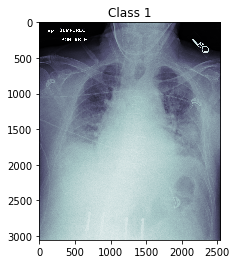

In [30]:
img_to_view = view_images[image_class]
if isinstance(img_to_view, str):
    img_to_view = load_image(img_to_view).pixel_array
show_image(img_to_view, "Class " + str(image_class))

## Load trained model and predict

In [31]:
# model checkpoint paths
ckpt_file = '/data/vision/polina/projects/chestxray/work_space/model_para_v8/100_30_model_classification_res_v1_4_3_maxpooling_0.05reg/model.ckpt-352985'
model_path = 'model_classification_res_v1_4_3_maxpooling'

In [11]:
sess = tf.Session()

# build model
model_module = importlib.import_module(model_path)
model = model_module.Model()
images = tf.placeholder(tf.float32, [1, img_to_feed.shape[0], img_to_feed.shape[1], 1])
train_mode = tf.placeholder(tf.bool)

model.build(images, train_mode)

# load trained model
saver = tf.train.Saver()
saver.restore(sess, ckpt_file)

# get important nodes
output = sess.graph.get_tensor_by_name('output_node:0')
conv1_1 = sess.graph.get_tensor_by_name('conv1_1/Conv2D:0')
res2_2 = sess.graph.get_tensor_by_name('res2_2/Conv2D:0')
conv4_1 = sess.graph.get_tensor_by_name('conv4_1/Conv2D:0')
res5_2 = sess.graph.get_tensor_by_name('res5_2/Conv2D:0')
conv7_1 = sess.graph.get_tensor_by_name('conv7_1/Conv2D:0')
res8_2 = sess.graph.get_tensor_by_name('res8_2/Conv2D:0')
conv10_1 = sess.graph.get_tensor_by_name('conv10_1/Conv2D:0')
res11_2 = sess.graph.get_tensor_by_name('res11_2/Conv2D:0')

conv1_1_filters
(7, 7, 1, 16)
(7, 7, 1, 16)
res2_1_filters
(5, 5, 16, 16)
(5, 5, 16, 16)
res2_2_filters
(5, 5, 16, 16)
(5, 5, 16, 16)
conv4_1_filters
(3, 3, 16, 32)
(3, 3, 16, 32)
res5_1_filters
(3, 3, 32, 32)
(3, 3, 32, 32)
res5_2_filters
(3, 3, 32, 32)
(3, 3, 32, 32)
conv7_1_filters
(3, 3, 32, 64)
(3, 3, 32, 64)
res8_1_filters
(3, 3, 64, 64)
(3, 3, 64, 64)
res8_2_filters
(3, 3, 64, 64)
(3, 3, 64, 64)
conv10_1_filters
(3, 3, 64, 128)
(3, 3, 64, 128)
res11_1_filters
(3, 3, 128, 128)
(3, 3, 128, 128)
res11_2_filters
(3, 3, 128, 128)
(3, 3, 128, 128)
fc13_weights
(2048, 256)
(2048, 256)
fc13_biases
(256,)
(256,)
fc14_weights
(256, 3)
(256, 3)
fc14_biases
(3,)
(3,)
INFO:tensorflow:Restoring parameters from /data/vision/polina/projects/chestxray/work_space/model_para_v8/100_30_model_classification_res_v1_4_3_maxpooling_0.05reg/model.ckpt-352985


In [32]:
out = sess.run(output, feed_dict={images: [img_to_feed], train_mode: False})[0]
print("output: " + str(out))

output: [0.92836523 0.80424565 0.38156226]


## Visualize using Grad-CAM

In [33]:
def show_original_image(img, title=''):
    plt.title(title)
    plt.imshow(img, cmap=plt.cm.bone)

def show_grayscale_image(img, title=''):
    plt.title(title)
    plt.imshow(img, cmap=plt.cm.gray)
  
### COLORS ###
# https://matplotlib.org/tutorials/colors/colormaps.html
# hot: 0->1 black->red->yellow
# spectral: 0->1 red->yellow->blue

def show_heatmap(img, title=''):
    plt.title(title)
    plt.imshow(img, cmap=plt.cm.jet, vmin=np.percentile(img, 10), vmax=np.percentile(img, 80))
    
def show_overlay(base_img, overlay_img, title=''):
    plt.title(title)
    plt.imshow(base_img, cmap=plt.cm.bone)
    plt.imshow(overlay_img, cmap=plt.cm.jet, alpha=0.15, vmin=np.percentile(overlay_img, 10), vmax=np.percentile(overlay_img, 80))

In [34]:
tensor_index = 0

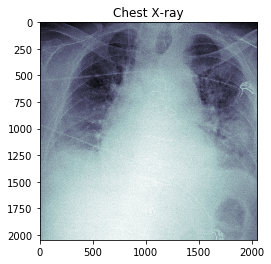

In [35]:
show_original_image(img, "Chest X-ray")

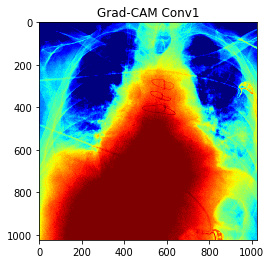

In [36]:
see_grad_cam_heatmap(conv1_1, tensor_index, "Conv1")

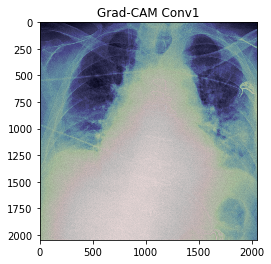

In [37]:
see_grad_cam_overlay(img, conv1_1, tensor_index, "Conv1")

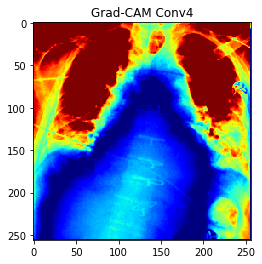

In [38]:
see_grad_cam_heatmap(conv4_1, tensor_index, "Conv4")

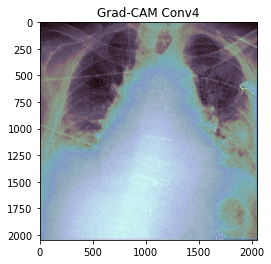

In [39]:
see_grad_cam_overlay(img, conv4_1, tensor_index, "Conv4")

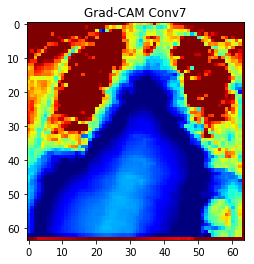

In [40]:
see_grad_cam_heatmap(conv7_1, tensor_index, "Conv7")

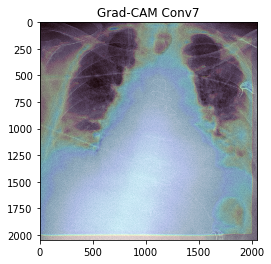

In [41]:
see_grad_cam_overlay(img, conv7_1, tensor_index, "Conv7")

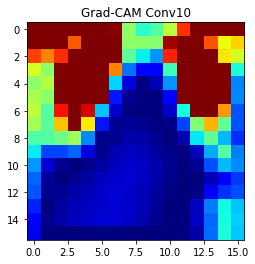

In [42]:
see_grad_cam_heatmap(conv10_1, tensor_index, "Conv10")

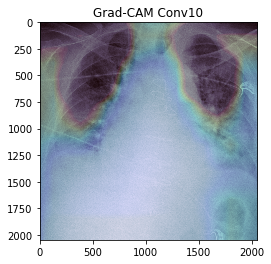

In [43]:
see_grad_cam_overlay(img, conv10_1, tensor_index, "Conv10")

## Clean resources

In [ ]:
# close session
sess.close()

## OLD STUFF

In [ ]:
for n in sess.graph.as_graph_def().node:
    if 'res' in n.name:
        print(n.name)

In [ ]:
def see_grad_cam_grayscale(layer, neuron_index, name=''):
    grad_cam = GradCam(model, sess, output[0][neuron_index], images, layer)
    grad_cam_mask = grad_cam.GetMask(img_to_feed, feed_dict={train_mode: False}, should_resize = False, three_dims = False)
    
    # Render the saliency mask.
    show_grayscale_image(grad_cam_mask, title='Grad-CAM ' + name)